# Creating gymnasium environment

### Explanations

The environment is:
 - A $N \times M$ grid of cases with $N,M \in \mathbb{N}$
 - Each case is in $\{0,1,3,4\}$ such that:
   - $0 \rightarrow$ road (white)
   - $1 \rightarrow$ wall (black)
   - $STAR\_ CHAR$ (3) $\rightarrow$ starting point
   - $END\_ CHAR$ (4) $\rightarrow$ ending point

 - A Car that follow some model for trajectory. The car can do the next action:
   - accelerate
   - brake
   - turn (you need to specifie the angle)
   - do nothing

To create your turn/your track, use the grid notation (for better visualisation) like env_01. The grid is used with the matrix notation. If we denote the grid by $G$, then $G[0][0]$ is the top left case, $G[x][y]$ is the case on the $x$-th row (from top to bottom) and on the $y$-th column (from left to right).

Nevertheless, for all the other things, we use axis coordinates, i.e., $G[x][y]$ refer to the case situate at coordinate $(x,y)$. More preciselly, it is the case on the $x$-th column (from left to right) and on the $y$-th row (from bottom to top). Therefore you can simply use `plt.plot(x,y, args**)` for ploting something at coordinate $(x,y)$ (see code for more example).

### Importing Packages

In [408]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

### Coor class

In [409]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        if coor2 == None:
            return False
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def __neg__(self):
        x,y = self.get()
        return Coor((-x,-y))
    
    def __sub__(self, coor2):
        coor = - coor2
        return self + coor
    
    def norm(self):
        x,y = self.get()
        return np.sqrt(x*x + y*y)
    
    def dist(self, coor2):
        return (self -coor2).norm()


### Track class

Contrary to previous environment, track are not matrix anymore.

In [410]:
RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [240 for _ in range(3)]

START_CHAR = 2
END_CHAR = 3
CAR_CHAR = 4

def color(b):
    if b == START_CHAR:
        return GREEN
    elif b == END_CHAR:
        return RED
    elif b == 1:
        return GREY
    else:
        return WHITE
    

class Track():
    def __init__(self, tab):
        #switching height and width for plan approach
        self.width: int = len(tab)
        self.height: int = len((tab[0]))
        self.basic_info_track:list = [[i for i in j] for j in tab]
        
        self.info_track:list = [[None for _ in range(self.height)] for _ in range(self.width)]
        for x in range(self.width):
            for y in range(self.height):
                self.info_track[x][y] = self.basic_info_track[self.height-1-y][x]

        self.color_track = [[color(self.info_track[y][x]) for y in range(self.height)] for x in range(self.width)]

        self.end = None
        self.start = None
        for i in range(self.height):
            for j in range(self.width):
                if self.info_track[i][j] == START_CHAR:
                    self.start = Coor((i,j))
                if self.info_track[i][j] == END_CHAR:
                    self.end = Coor((i,j))

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        nx,ny = int(round(x)), int(round(y))
        return (self.info_track[nx][ny] == 1)

    def get_start(self):
        """Return coordinate of start"""
        if self.start == None:
            return None
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()
    
    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the coordinate or not"""
        x,y = coor.get()
        if not (x>=0 and x<self.width and y>=0 and y<self.height):
            return False
        return not self.is_wall(coor)

    def plot(self, hide=False):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track, origin='lower')
        # for x in range(self.width):
        #     for y in range(self.height):
        #         plt.text(x, y, str(x) + " " + str(y))
        plt.axis("off")
        if not hide:
            plt.show()

### Creating the track

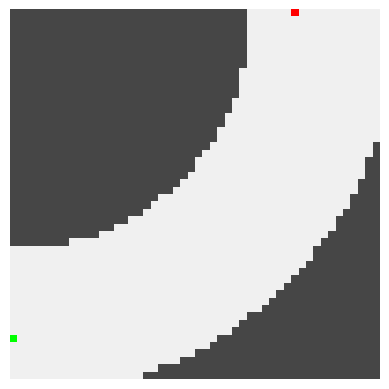

track shape: 50 50
start at coordinates: (0, 5)
end at coordinates: (38, 49)


In [411]:
def place_circle(tab, r, pos: Coor, symbol):
    height = len(tab)
    width = len(tab[0])
    for i in range(height):
        for j in range(width):
            if pos.dist(Coor((i,j))) < r:
                tab[i][j] = symbol
    return tab

N = 50
turn_1 = [[1 for _ in range(N)] for _ in range(N)]
turn_1 = place_circle(turn_1, 52, Coor((0, 0)), 0)
turn_1 = place_circle(turn_1, 32, Coor((0, 0)), 1)
turn_1[N-6][0] = START_CHAR
turn_1[0][N-12] = END_CHAR

track_1 = Track(turn_1)
track_1.plot()
print("track shape:", track_1.height, track_1.width)
print("start at coordinates:", track_1.start)
print("end at coordinates:", track_1.end)

### Car class

Car has $2$ main variable:
 - speed: $v$
 - alpha: $\alpha$ suppose to be between $0$ and $360$

To calculate the $x$-speed and $y$-speed we use the next formulas:
 - $v_x = v.cos(\alpha . \frac{\pi}{180})$
 - $v_y = v.sin(\alpha . \frac{\pi}{180})$

In [425]:
"""Constant"""


"""Class"""
class Car():
    def __init__(self, coor:Coor):
        self.coor: Coor = Coor((coor.x, coor.y))
        self.speed: float = 0
        self.alpha: float = 0 # The angle of the car according to unitary cicrle
        self.trajectory = [Coor((coor.x, coor.y))]

    def __str__(self):
        return "C[" + str(self.coor) + " " + str(self.speed) + " " + str(self.alpha) + "]"
    

    def accelerate(self, amont=1):
        """Increase speed of the car"""
        acceleration_constant = 1
        self.speed += acceleration_constant*amont

    def brake(self, amont=1):
        """Decrease speed of the car (can't drive backward)"""
        brake_constant = 1.5
        self.speed /= (brake_constant*amont)
        if self.speed < 0.01:
            self.speed = 0

    def turn(self, deg):
        """Change the current rotation of the car"""
        self.alpha += deg
        self.alpha = self.alpha % 360

    def get_speed_coor(self):
        cst: float = np.pi / 180
        dx: float = self.speed * np.cos(self.alpha * cst)
        dy: float = self.speed * np.sin(self.alpha * cst)
        return Coor((dx,dy))

    def move(self):
        """Change the coordinate of the care according to its speed and alpha"""
        dx,dy = self.get_speed_coor().get()
        self.coor.x += dx
        self.coor.y += dy
        self.trajectory.append(Coor((self.coor.x, self.coor.y)))

    def dic(self):
        return {"coor":self.coor, "speed":self.speed, "alpha":self.alpha, "trajectory":self.trajectory}

    def plot(self, markersize=8, vector_constant=2, show_trajectory=False, head_width=1):
        """Plot the car and is speed vectors"""
        # Plot car
        x,y = self.coor.get()
        plt.plot(x, y, "o", color='blue', markersize=markersize)
        plt.axis("off")

        # Plot 
        if show_trajectory:
            liste_x = [coor.x for coor in self.trajectory]
            liste_y = [coor.y for coor in self.trajectory]
            plt.plot(liste_x, liste_y, "-o", color="blue", markersize=2)
                 

        # Plot car's directoin
        cst: float = np.pi / 180
        dx: float = np.cos(self.alpha * cst)
        dy: float = np.sin(self.alpha * cst)
        plt.arrow(x, y, dx/10, dy/10, head_width=head_width)
        plt.plot([x, x+ dx*self.speed*vector_constant], [y, y+ dy*self.speed*vector_constant], "-", color="red")


### Car exemple

##### Ploting car

(0, 5)
(0, 5)


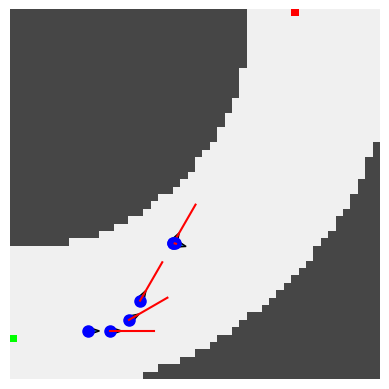

In [419]:
track_1.plot(hide=True)
print(track_1.start)

car = Car(Coor((10,6)))
car.plot()

car.accelerate()
car.accelerate()
car.accelerate()
car.move()
car.plot()

car.turn(30)
car.move()
car.plot()

car.turn(30)
car.move()
car.plot()

car.move()
car.move()
car.move()
car.plot()

car.turn(-75)
car.brake()
car.brake()
car.brake()
car.plot()

car.brake()
car.brake()
car.move()
car.move()
car.plot()

print(track_1.start)
plt.show()

##### Showing trajectory

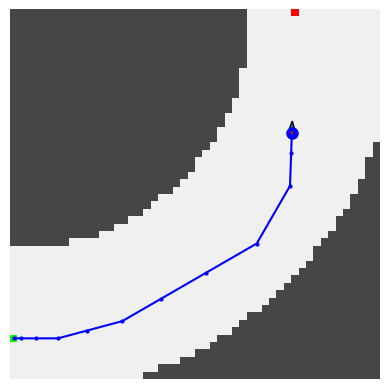

In [420]:
track_1.plot(hide=True)
car = Car(track_1.start)

car.accelerate()
car.move()
car.accelerate()
car.move()
car.accelerate()
car.move()
car.accelerate()
car.turn(15)
car.move()
car.accelerate()
car.move()
car.accelerate()
car.turn(15)
car.move()
car.accelerate()
car.move()
car.accelerate()
car.move()
car.accelerate()
car.turn(30)
car.move()
car.brake()
car.turn(28)
car.move()
car.brake()
car.move()
car.brake()
car.brake()
car.brake()
car.move()
car.brake()
car.brake()
car.move()
car.brake()
car.move()
car.move()

car.plot(show_trajectory=True)
plt.show()

##### Ridable case

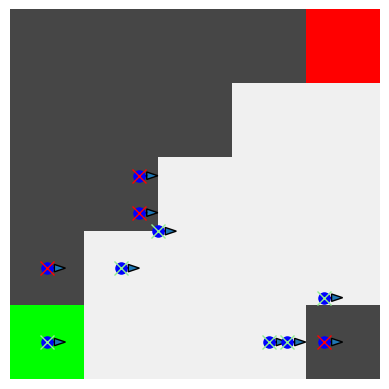

In [415]:
track_2_info = [[1, 1, 1, 1, END_CHAR],
                [1, 1, 1, 0, 0],
                [1, 1, 0, 0, 0],
                [1, 0, 0, 0, 0],
                [START_CHAR, 0, 0, 0, 1]]

track_2 = Track(track_2_info)
track_2.plot(hide=True)

car_list = [
    Car(Coor((0,0))),
    Car(Coor((0,1))),
    Car(Coor((1,1))),
    Car(Coor((1.5,1.5))),
    Car(Coor((1.25,1.75))),
    Car(Coor((1.25,2.25))),
    Car(Coor((3, 0))),
    Car(Coor((3.25, 0))),
    Car(Coor((3.75, 0))),
    Car(Coor((3.75, 0.6)))
]

for car in car_list:
    car.plot(markersize=8, head_width=0.1)
    b = track_2.is_case_ridable(car.coor)
    color = 'lightgreen' if b else 'red'
    plt.plot(car.coor.x, car.coor.y, "x", color=color, markersize=10)

plt.show()

### Gym env

An anction is a $(a,b) \in \{-1,0,1\} \times \{-K,K\}$ where $K$ is a constant that define the maximum angle the car can turn in one movement.
 - -1 is for brake
 - 1 for accelearation
 - 0 for nothing.

In [430]:
class MyEnv(Env):
    def __init__(self, track: Track):
        super(MyEnv, self).__init__()
        self.max_turn = 10
        # Define an action space ranging from 0 to 3
        self.action_space = [i for i in range(4)]

        self.track: Track = track
        self.car: Car = Car(track.start)

        self.canvas = np.array(self.track.color_track)


    def get_state(self):
        """Return actual state of the env"""
        state = np.array(self.track.info_track)
        return state, [val for _,val in self.car.dic().items()]

    def reset(self):
        """Reset the environment"""
        self.car = Car(self.track.start)
        return self.canvas

    def render(self, waiting_time=0.01):
        """Render the environment"""
        self.track.plot(hide=True)
        self.car.plot(show_trajectory=True)
        display.clear_output(wait=True)
        plt.show()
        time.sleep(waiting_time)
        
        
    def step(self, action):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        arrival = False

        reward = -1

        previous_dist = self.car.coor.dist(self.track.start)
        if action[0]==-1:
            self.car.brake()
        elif action[0]==1:
            self.car.accelerate()
        self.car.turn(action[1]*self.max_turn)
        self.car.move()

        new_dist = self.car.coor.dist(self.track.start)
        #reward += 2 *(new_dist - previous_dist)

        if not self.track.is_case_ridable(self.car.coor):
            reward = -100
            is_done = True

        if self.car.coor.dist(self.track.end) <= 0.5:
            reward = 200
            arrival = True
            is_done = True

        return self.canvas, reward, is_done, [arrival]
    
    def random_action(self, p_accel=0.25, p_brake=0.25, p_turn=0.5):
        """Return random possible action according to probability"""
        action = [0,0]
        rd_accel = rd.random()
        if rd_accel <= p_accel:
            action[0] = 1
        elif rd_accel <= p_accel + p_brake:
            action[0] = -1
        
        if rd.random() <= p_turn:
            action[1] = (-1)**(rd.randint(0,1))
        return action

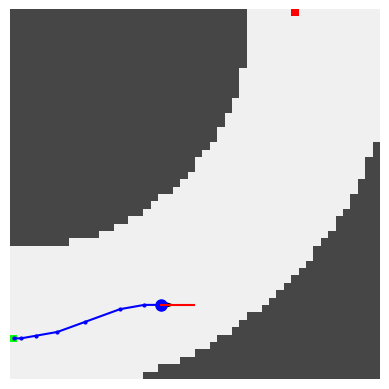

In [434]:
env = MyEnv(track_1)
env.render()
env.step([1,0])
env.step([1,1])
env.step([1,0])
env.step([1,1])
env.step([1,0])
env.step([-1,-1])
env.step([-1,-1])
env.render()
env.close()